# Data Exploration Notebook

Goal of this notebook is just to examine tensors and stuff, determine dimensions/interpretations.

In [19]:
import torch
import pickle
import cv2
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from typing import NamedTuple
from collections import namedtuple

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_hands = mp.solutions.hands

TEST_DATA_PATH = r"D:\School\Winter 2024\CSE 517\project\data-expanded\general-conference-october-2023-general-conference-2023-10-1010-david-a-bednar-1080p-ase.pickle"

# Load data into pytorch
with open(TEST_DATA_PATH, 'rb') as f:
    test_data = pickle.load(f)
# Print dimensions
print(test_data.shape)

torch.Size([26198, 1629])


In [7]:
test_data[1000]

tensor([ 0.7274,  0.3088, -0.5650,  ...,  0.5403,  0.5847, -0.0396])

In [14]:
test_data.type()

'torch.FloatTensor'

In [15]:
1629 / 3

543.0

In [9]:
# The Tensor files created by Aragorn's code smush the landmarks from the MediaPipe output together in
# an implementation-defined way: https://gitlab.cs.washington.edu/aracro/sign-language-translation/-/blob/transformer/src/utils.py?ref_type=heads#L218
# We need to reverse engineer this for preprocessing to be able to determine which indices actually mean
# what.

# NOTE: each landmark has 3 coordinates (x,y,z) in that order. Within each landmark set (e.g.: pose landmarks,
# or hand landmarks) defined by MediaPipe, the indices have assigned joint meanings that can be found in the
# MediaPipe docs. e.g.: For hands consult: https://github.com/google/mediapipe/blob/master/docs/solutions/hands.md

# Aragorn's appends the landmark sets in this order:
# [0,33) 33 Pose Landmarks: https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md
# [33, 501) 468 Face Mesh landmarks: https://github.com/google/mediapipe/blob/master/docs/solutions/face_mesh.md
# [501, 522) 21 Left hand landmarks: https://github.com/google/mediapipe/blob/master/docs/solutions/hands.md
# [522, 543) 21 Right hand landmarks: Same as left hand.

# I'm referring to this file format as `araform` (Aragorn's Format) in code.

# Number of landmarks for each landmark set.
NUM_POSE_LMS = 33
NUM_FACE_LMS = 468
NUM_LHAND_LMS = 21
NUM_RHAND_LMS = 21
TOTAL_LMS = NUM_POSE_LMS + NUM_FACE_LMS + NUM_LHAND_LMS + NUM_RHAND_LMS

ARAFORM_LELBOW_ID = 13
ARAFORM_RELBOW_ID = 14
ARAFORM_LWRIST_ID = 15
ARAFORM_RWRIST_ID = 16

# Total number of datapoints should be 3 * TOTAL_LMS (since each landmark has 3 coordinates).
assert test_data.shape[-1] == TOTAL_LMS * 3

In [12]:
# Landmark indices for reduced form
REDUCED_NOSE = 0
REDUCED_LELBOW = 1
REDUCED_RELBOW = 2
REDUCED_LWRIST = 3
REDUCED_RWRIST = 4
REDUCED_LHAND_START = 5
REDUCED_LHAND_END = 26
REDUCED_RHAND_START = 26
REDUCED_RHAND_END = 47

def araform_to_reduced(araform_tensor: torch.Tensor) -> torch.Tensor:
    """
    Returns a reduced form of Araform where unnecessary points are removed.
    We filter down to just the left and right hand, as well as the elbows and neck
    positions.

    This is "reduced" format. Landmark indices (note in actual tensor the first datapoint
    for each landmark tensor is 3*index due to how each landmark has 3 coordinates):
    - 0: Nose
    - 1: Left Elbow
    - 2: Right Elbow
    - 3: Left Wrist
    - 4: Right wrist
    - [5, 26): Left hand landmarks
    - [26, 47): Right hand landmarks 
    """
    assert araform_tensor.shape[-1] == TOTAL_LMS * 3
    # The ranges of LMs we want are [501, to the end), and 
    # Following advice here to just use boolean masks: https://stackoverflow.com/questions/61034839/pytorch-indexing-a-range-of-multiple-indices
    mask = torch.arange(TOTAL_LMS * 3)
    # 0 gives us nose, [13,17) gives us elbows and wrists, [501,) gives us the hands
    # Have to remember to multiply by 3 since all of these things are splatted out into 3 coords.
    mask = (mask < (1 * 3)) | ((ARAFORM_LELBOW_ID * 3 <= mask) & (mask < (ARAFORM_RWRIST_ID + 1) * 3)) | (501 * 3 <= mask)

    # Use mask to select along the last dimension (i.e.: the actual datapoints)
    result = araform_tensor[..., mask]

    assert result.shape[-1] == 47 * 3
    return result

def reduced2lhand(reduced_tensor: torch.Tensor) -> torch.Tensor:
    """
    Convert a reduced_tensor to a tensor that only has the coordinates for left hand LMs
    """
    assert reduced_tensor.shape[-1] == REDUCED_RHAND_END * 3
    return reduced_tensor[..., REDUCED_LHAND_START*3:REDUCED_LHAND_END*3]


reduced_test_data = araform_to_reduced(test_data)

In [21]:
reduced_test_data.shape

torch.Size([26198, 141])

In [17]:
from mediapipe.framework.formats import landmark_pb2

# Create a function that only keeps frames where the wrist is above elbow.
def filter_to_coding(reduced_data) -> torch.Tensor:
    """
    Preprocess a reduced form tensor to only contain frames where at least one
    wrist is above elbow
    """

def hand_tensor_to_normalized_landmark_list(hand_tensor: torch.Tensor) -> landmark_pb2.NormalizedLandmarkList:
    """
    Takes in a tensor of 21 * 3 floats (for a hand's landmarks) and returns a  corresponding
    NormalizedLandmarkList protobuf object (which is what MediaPipe originally returns
    from `process` call). This NormalizedLandmarkList should then be usable for drawing
    using `mp_drawing.draw_landmarks`.
    """
    assert len(hand_tensor.shape) == 1
    assert hand_tensor.shape[-1] == NUM_LHAND_LMS * 3

    retval = landmark_pb2.NormalizedLandmarkList()
    for i in range(NUM_LHAND_LMS):
        lm_offset = i*3
        # Add the next landmark
        lm = retval.landmark.add()
        lm.x = hand_tensor[lm_offset + 0]
        lm.y = hand_tensor[lm_offset + 1]
        lm.z = hand_tensor[lm_offset + 2]

    return retval

def batch_hand_tensor_to_normalized_landmark_list(hand_tensors: torch.Tensor) -> list[landmark_pb2.NormalizedLandmarkList]:
    """
    Like `hand_tensor_to_normalized_landmark_list` except `hand_tensor` is expected to be 2D, where first dimension indexes
    over batches.
    """
    assert len(hand_tensors.shape) == 2
    assert hand_tensors.shape[-1] == NUM_LHAND_LMS * 3
    result = []
    # NOT YET IMPLEMENTED 
    pass 



"""
1) "pose_landmarks" field that contains the pose landmarks.
2) "pose_world_landmarks" field that contains the pose landmarks in
real-world 3D coordinates that are in meters with the origin at the
center between hips.
3) "left_hand_landmarks" field that contains the left-hand landmarks.
4) "right_hand_landmarks" field that contains the right-hand landmarks.
5) "face_landmarks" field that contains the face landmarks.
"""
MediaPipeResult = namedtuple("MediaPipeResult", "")
def araform_to_mediapipe_result() -> NamedTuple:
    pass
    
    
def reduced_frame_to_image(reduced_frame: torch.Tensor, out_path="test.png"):
    """
    Visualize the 
    """

    # mp_landmarks = reduced_frame_to_landmarks
    pass


In [15]:
mp_holistic.POSE_CONNECTIONS

frozenset({(0, 1),
           (0, 4),
           (1, 2),
           (2, 3),
           (3, 7),
           (4, 5),
           (5, 6),
           (6, 8),
           (9, 10),
           (11, 12),
           (11, 13),
           (11, 23),
           (12, 14),
           (12, 24),
           (13, 15),
           (14, 16),
           (15, 17),
           (15, 19),
           (15, 21),
           (16, 18),
           (16, 20),
           (16, 22),
           (17, 19),
           (18, 20),
           (23, 24),
           (23, 25),
           (24, 26),
           (25, 27),
           (26, 28),
           (27, 29),
           (27, 31),
           (28, 30),
           (28, 32),
           (29, 31),
           (30, 32)})

## Testing Plotting

Simple verification of plotting methods. Convert from Tensor form to NormalizedLandmarkList, then plot using
`mp


In [13]:
# Arbitrarily select a frame of coordinates
reduced_test_frame = reduced_test_data[10000]
# Get the hand
lhand_test_frame = reduced2lhand(reduced_test_frame)
lhand_test_frame

tensor([ 6.1727e-01,  7.8073e-01,  1.3788e-07,  6.3553e-01,  7.6182e-01,
        -8.0021e-03,  6.4760e-01,  7.3974e-01, -1.5713e-02,  6.5694e-01,
         7.2665e-01, -2.4162e-02,  6.6811e-01,  7.2408e-01, -3.2751e-02,
         6.3909e-01,  6.7354e-01, -7.8145e-03,  6.3821e-01,  6.3101e-01,
        -1.8874e-02,  6.4445e-01,  6.1767e-01, -2.8019e-02,  6.5207e-01,
         6.1634e-01, -3.3266e-02,  6.2655e-01,  6.7442e-01, -1.0158e-02,
         6.2578e-01,  6.2901e-01, -1.9668e-02,  6.3335e-01,  6.1617e-01,
        -2.7063e-02,  6.4248e-01,  6.1679e-01, -3.1385e-02,  6.1463e-01,
         6.8385e-01, -1.3829e-02,  6.1177e-01,  6.4117e-01, -2.0680e-02,
         6.1776e-01,  6.2435e-01, -2.4906e-02,  6.2662e-01,  6.1855e-01,
        -2.7195e-02,  6.0237e-01,  7.0021e-01, -1.8557e-02,  5.9800e-01,
         6.6554e-01, -2.2975e-02,  6.0122e-01,  6.4461e-01, -2.4714e-02,
         6.0775e-01,  6.3052e-01, -2.5550e-02])

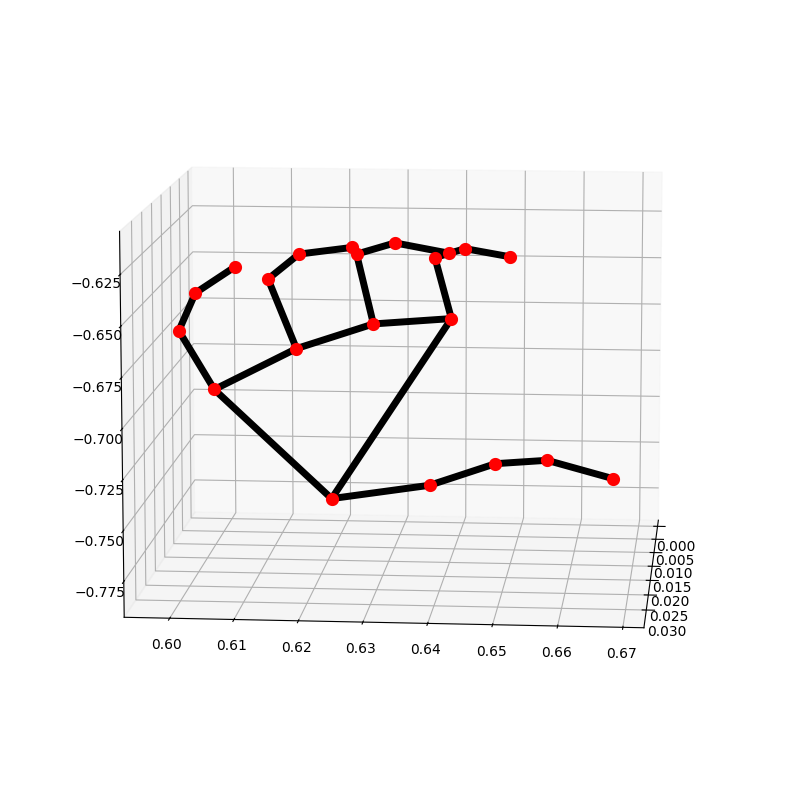

In [28]:
# Convert to Protobuf
lhand_lms = hand_tensor_to_normalized_landmark_list(lhand_test_frame)
mp_drawing.plot_landmarks(lhand_lms, mp_hands.HAND_CONNECTIONS, azimuth=5)

## Plotting Two Hands

Now time for a second exercise! Let's see if we can plot two hands at once (with elbows ideally). This will require generating a new `connections` list which the `plot_landmarks` function will use for determining when/where to draw lines. If we write a simple map function on the original set of tuples (that just increments all start and end hand landmarks by some amount), then for the input landmarks just append the left hand and right hand landmarks we should be cooking with gas.